<a ><font size="4"><b> Setup and load dependencies</b></font></a>


In [533]:
cd /mnt/d/AI/Algerian Forest Fire Prediction

/mnt/d/AI/Algerian Forest Fire Prediction


In [534]:
# Import libraries
import os
import pandas as pd
import numpy as np

# import statsmodels.api as sm
# from statsmodels.stats.power import TTestIndPower, TTestPower
# from scipy.stats import skew, norm, kurtosis
# from scipy import stats 

import matplotlib.pyplot as plt
import seaborn as sns
# import missingno as msno

# from sklearn.preprocessing import StandardScaler
# from sklearn.cluster import KMeans
# from sklearn.manifold import TSNE
# from sklearn.metrics import silhouette_score

# from yellowbrick.cluster import KElbowVisualizer
from IPython.core.interactiveshell import InteractiveShell

In [535]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [536]:
# use the following to suppress scientific notation in Pandas
pd.set_option('display.float_format', lambda x: '%.3f' % x)
# Set the maximum number of rows and columns to display
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

sns.set_context('talk')
InteractiveShell.ast_node_interactivity = "all"

# colors = sns.cubehelix_palette(20,reverse = True, light= 0.01,dark = 0.5, gamma= 0.7)
palette_color  = sns.color_palette("RdBu",5)
sns.set_theme(style="whitegrid", palette=palette_color)

# colors
palette_color

[(0.7893886966551327, 0.2768166089965398, 0.2549019607843137),
 (0.9686274509803922, 0.7176470588235293, 0.5999999999999999),
 (0.9657054978854287, 0.9672433679354094, 0.9680891964628989),
 (0.654901960784314, 0.8143790849673205, 0.8941176470588236),
 (0.21568627450980393, 0.5141868512110727, 0.7328719723183391)]

<h1 ><font ><b>Helper Functions</b></font></h1>


In [537]:
# crdits: https://www.kaggle.com/fabiendaniel/elo-world
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df.dtypes

In [538]:
def CheckMissing(df):
    missing = df.isna().sum().sort_values(ascending = False)
    missing = missing[missing > 0]
    if missing.sum()!=0: 
        missing_percent = missing / len(df) * 100

        missing_info = pd.DataFrame({
            'Feature': missing.index,
            'NumMissing': missing.values,
            'PercentMissing':missing_percent.values,
            'NumUnique': df[missing.index].nunique().values,
            'MostCommon': df[missing.index].mode().iloc[0].values
        })

        return missing_info
    else: 
        print("Dataset has No Nulls")
        return 0

<a ><font size="3"><b>Descriptive statistics</b></font></a>

Here are some common descriptive statistics measures:

- Measures of central tendency: Mean, Median, and Mode.
- Measures of variability: Variance, Standard deviation, and Range.
- Measures of shape:
    - Skewness: the degree of asymmetry of the data.
    - Kurtosis: the degree of peakedness or flatness of the data.

In [539]:
def DescriptiveStats(df):
    stats_df = df.describe(include = 'all').transpose()
    stats_df['skewness'] = np.nan
    stats_df['kurtosis'] = np.nan
    for col in df.select_dtypes([np.number]).columns.to_list():

        stats_df.loc[col,'unique'] = df[col].nunique()
        stats_df.loc[col,'top'] = df[col].mode()[0]
        stats_df.loc[col,'freq'] = df[col].value_counts().values[0]
        stats_df.loc[col,'skewness'] = df[col].skew()
        stats_df.loc[col,'kurtosis'] = df[col].kurtosis()
   
    return stats_df

In [596]:
def n_cat_samples(df,cat_cols,target_col, num_bins=20, figsize=(7, 5), pie=True):
    
    InteractiveShell.ast_node_interactivity = 'last_expr'
    
    fig, axs = plt.subplots(nrows=len(cat_cols)+1, ncols=2, figsize=figsize)
    # Create a pie plot for each categorical column
    for i, feature in enumerate(cat_cols):

        value_counts = df[feature].value_counts().sort_values()

        if pie:
        
            axs[i, 0].pie(value_counts, labels=value_counts.index, 
                            colors=palette_color, autopct='%1.1f%%', pctdistance=1.2, 
                            labeldistance=1.5, textprops={'fontsize': 8})

        sns.countplot(x=feature, data=df,ax=axs[i, 1],palette=palette_color, hue=target_col)

        axs[i, 0].set_title(feature, loc='left',fontsize=12, pad = 30)
        axs[i, 1].set_xlabel('', fontsize=10, rotation= 60)
        axs[i, 1].set_ylabel('', fontsize=10)
    
    axs[-1,0].remove()
    axs[-1,1].remove()
    
    plt.tight_layout(h_pad =0.5, pad=0.5)
    plt.legend(loc='best')
    plt.show()

### Dataset overview

In [557]:
df = pd.read_csv('data/raw/Algerian_forest_fires_dataset.csv')

In [558]:
InteractiveShell.ast_node_interactivity = 'all'
df.shape
df.info()

(247, 14)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 247 entries, 0 to 246
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   day          246 non-null    object
 1   month        245 non-null    object
 2   year         245 non-null    object
 3   Temperature  245 non-null    object
 4    RH          245 non-null    object
 5    Ws          245 non-null    object
 6   Rain         245 non-null    object
 7   FFMC         245 non-null    object
 8   DMC          245 non-null    object
 9   DC           245 non-null    object
 10  ISI          245 non-null    object
 11  BUI          245 non-null    object
 12  FWI          245 non-null    object
 13  Classes      244 non-null    object
dtypes: object(14)
memory usage: 27.1+ KB


### Chcek missing values

In [559]:
CheckMissing(df)

,Feature,NumMissing,PercentMissing,NumUnique,MostCommon
0,Classes,3,1.215,9,fire
1,month,2,0.810,5,7
2,RH,2,0.810,63,55
3,Temperature,2,0.810,20,35
4,Ws,2,0.810,19,14
5,year,2,0.810,2,2012
6,DC,2,0.810,199,8
7,Rain,2,0.810,40,0
8,DMC,2,0.810,167,7.9
9,FFMC,2,0.810,174,88.9


In [560]:
df[df.isna().any(axis=1)]

,day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes
122,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
123,Sidi-Bel Abbes Region Dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
168,14,7,2012,37,37,18,0.2,88.9,12.9,14.6 9,12.5,10.4,fire,NaN


* **Row 168:** The `Classes` value is corrected to `'fire'` but its value written in the FWI column.

In [561]:
df.iloc[168,-2]=np.NaN
df.iloc[168,-1]='fire'

In [562]:
df[df.isna().any(axis=1)]

,day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes
122,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
123,Sidi-Bel Abbes Region Dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
168,14,7,2012,37,37,18,0.2,88.9,12.9,14.6 9,12.5,10.4,NaN,fire


> As describe in the dataset , all rows from 0 to 122 (inclusive) were assigned to the "Bejaia region" and all rows from 124 onwards were assigned to "Sidi-Bel Abbes".

In [563]:
df['Region'] = np.NaN
df.loc[:122, "Region"]='Bejaia region'
df.loc[125:, "Region"]='Sidi-Bel Abbes'

/tmp/ipykernel_11412/1028272941.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Bejaia region' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[:122, "Region"]='Bejaia region'


In [564]:
df = df.dropna()

In [565]:
CheckMissing(df)

Dataset has No Nulls


0

### Handle Column Types

In [566]:
df.columns
df.columns = df.columns.str.strip()
df.columns

Index(['day', 'month', 'year', 'Temperature', ' RH', ' Ws', 'Rain ', 'FFMC',
       'DMC', 'DC', 'ISI', 'BUI', 'FWI', 'Classes  ', 'Region'],
      dtype='object')

Index(['day', 'month', 'year', 'Temperature', 'RH', 'Ws', 'Rain', 'FFMC',
       'DMC', 'DC', 'ISI', 'BUI', 'FWI', 'Classes', 'Region'],
      dtype='object')

In [567]:

df = df.astype({
    'Classes': 'category',
    'Region': 'category',
    'month': 'int',
    'RH': 'int',
    'Temperature': 'int',
    'Ws': 'int',
    'year': 'int',
    'DC': 'float',
    'Rain': 'float',
    'DMC': 'float',
    'FFMC': 'float',
    'BUI': 'float',
    'ISI': 'float',
    'FWI': 'float',
    'day': 'int'
})

print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 243 entries, 0 to 246
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   day          243 non-null    int64   
 1   month        243 non-null    int64   
 2   year         243 non-null    int64   
 3   Temperature  243 non-null    int64   
 4   RH           243 non-null    int64   
 5   Ws           243 non-null    int64   
 6   Rain         243 non-null    float64 
 7   FFMC         243 non-null    float64 
 8   DMC          243 non-null    float64 
 9   DC           243 non-null    float64 
 10  ISI          243 non-null    float64 
 11  BUI          243 non-null    float64 
 12  FWI          243 non-null    float64 
 13  Classes      243 non-null    category
 14  Region       243 non-null    category
dtypes: category(2), float64(7), int64(6)
memory usage: 27.5 KB
None


In [568]:
reduce_mem_usage(df)

Mem. usage decreased to  0.01 Mb (71.5% reduction)


day                int8
month              int8
year              int16
Temperature        int8
RH                 int8
Ws                 int8
Rain            float16
FFMC            float16
DMC             float16
DC              float16
ISI             float16
BUI             float16
FWI             float16
Classes        category
Region         category
dtype: object

---
<h1 style="text-align:center;"><font color = "#2471A3">Data Exploration and Features Extaction</font></h1>

---

### 1. Distribution of Categorical Features


In [569]:
df.Classes.value_counts()

Classes
fire             131
not fire         101
fire               4
fire               2
not fire           2
not fire           1
not fire           1
not fire           1
Name: count, dtype: int64

In [588]:
df.Classes = df.Classes.str.strip()
print("\nFire vs. No Fire Counts:")
df.Classes.value_counts(normalize=True)


Fire vs. No Fire Counts:


Classes
fire       0.564
not fire   0.436
Name: proportion, dtype: float64

/tmp/ipykernel_11412/3447385997.py:17: UserWarning: The palette list has more values (5) than needed (2), which may not be intended.
  sns.countplot(x=feature, data=df,ax=axs[i, 1],palette=palette_color, hue=target_col)
/tmp/ipykernel_11412/3447385997.py:17: UserWarning: The palette list has more values (5) than needed (2), which may not be intended.
  sns.countplot(x=feature, data=df,ax=axs[i, 1],palette=palette_color, hue=target_col)
/tmp/ipykernel_11412/3447385997.py:17: UserWarning: The palette list has more values (5) than needed (2), which may not be intended.
  sns.countplot(x=feature, data=df,ax=axs[i, 1],palette=palette_color, hue=target_col)
/tmp/ipykernel_11412/3447385997.py:17: UserWarning: The palette list has more values (5) than needed (2), which may not be intended.
  sns.countplot(x=feature, data=df,ax=axs[i, 1],palette=palette_color, hue=target_col)


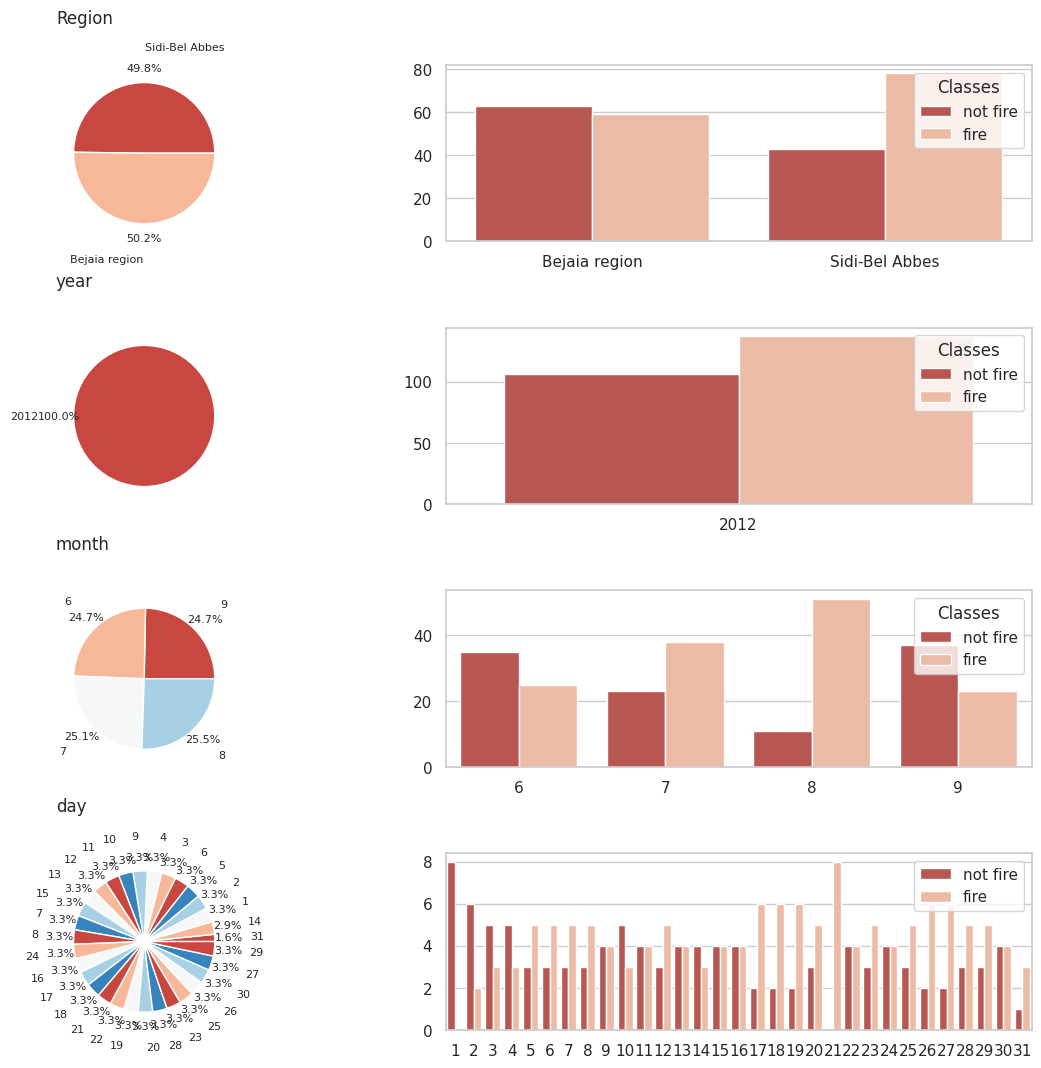

In [597]:
InteractiveShell.ast_node_interactivity = 'last_expr'
n_cat_samples(df, ['Region', 'year', 'month', 'day'], target_col='Classes', figsize=(12,13))

### 2. Relationship between Categorical Features and Fire Occurrence

In [608]:
categorical_features = ['month', 'Region','day']

for col in categorical_features:
    print(f"\n{col}-wise Fire Occurrence:")
    # info_df = df.groupby(col)['Classes'].value_counts().unstack()
    info_df=pd.crosstab(df['Classes'],df[col])
    print(info_df)


month-wise Fire Occurrence:
month      6   7   8   9
Classes                 
fire      25  38  51  23
not fire  35  23  11  37

Region-wise Fire Occurrence:
Region    Bejaia region  Sidi-Bel Abbes
Classes                                
fire                 59              78
not fire             63              43

day-wise Fire Occurrence:
day       1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16  17  \
Classes                                                                        
fire       0   2   3   3   5   5   5   5   4   3   4   5   4   3   4   4   6   
not fire   8   6   5   5   3   3   3   3   4   5   4   3   4   4   4   4   2   

day       18  19  20  21  22  23  24  25  26  27  28  29  30  31  
Classes                                                           
fire       6   6   5   8   4   5   4   5   6   6   5   5   4   3  
not fire   2   2   3   0   4   3   4   3   2   2   3   3   4   1  


In [ ]:
# Null Hypothesis:  Fire occurrence is independent of the region.
# Alternative Hypothesis:  Fire occurrence is dependent on the region.
observed = pd.crosstab(df['Region'], df['Classes'])
chi2_statistic, p_value, dof, expected = stats.chi2_contingency(observed)
print(f"Region vs. Fire Occurrence: chi2-statistic = {chi2_statistic:.3f}, p-value = {p_value:.4f}")

Region vs. Fire Occurrence: chi2-statistic = 5.767, p-value = 0.0163


In [612]:
# Null Hypothesis:  Fire occurrence is independent of the month.
# Alternative Hypothesis:  Fire occurrence is dependent on the month.
observed = pd.crosstab(df['month'], df['Classes'])
chi2_statistic, p_value, dof, expected = stats.chi2_contingency(observed)
print(f"Region vs. Fire Occurrence: chi2-statistic = {chi2_statistic:.3f}, p-value = {p_value:.4f}")

Region vs. Fire Occurrence: chi2-statistic = 30.978, p-value = 0.0000


In [ ]:
# Null Hypothesis:  Fire occurrence is independent of the day.
# Alternative Hypothesis:  Fire occurrence is dependent on the day.
observed = pd.crosstab(df['day'], df['Classes'])
chi2_statistic, p_value, dof, expected = stats.chi2_contingency(observed)
print(f"Region vs. Fire Occurrence: chi2-statistic = {cxhi2_statistic:.3f}, p-value = {p_value:.4f}")

Region vs. Fire Occurrence: chi2-statistic = 32.212, p-value = 0.3577


### 3. Distribution of Numerical Features

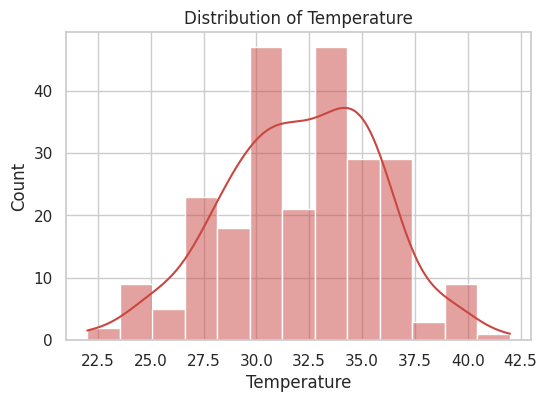

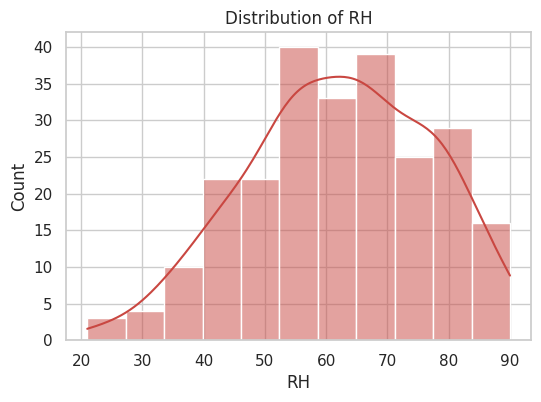

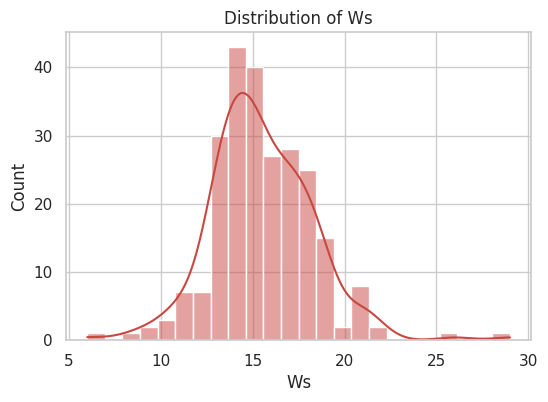

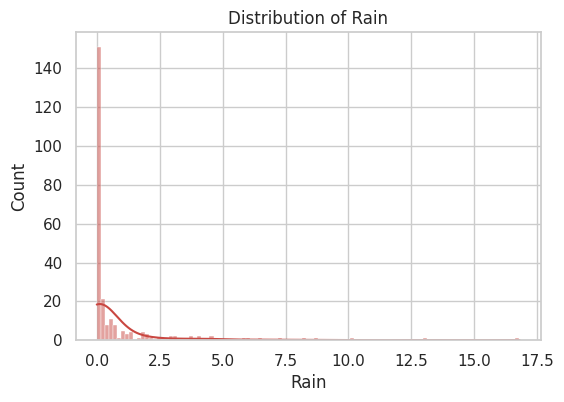

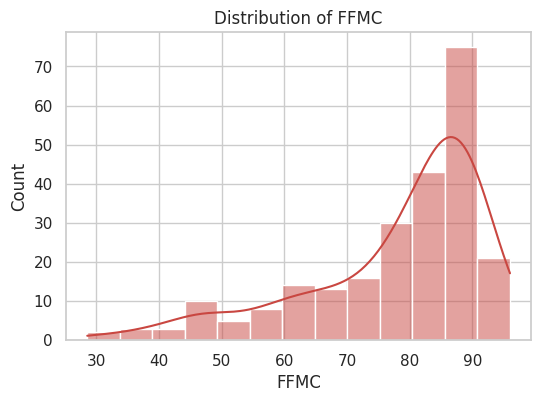

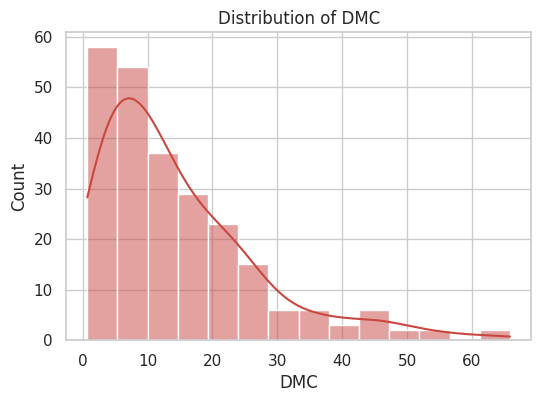

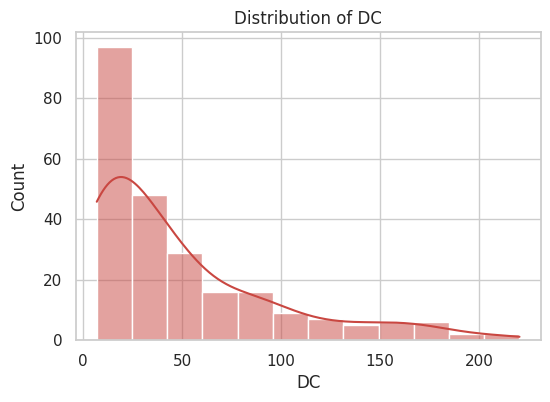

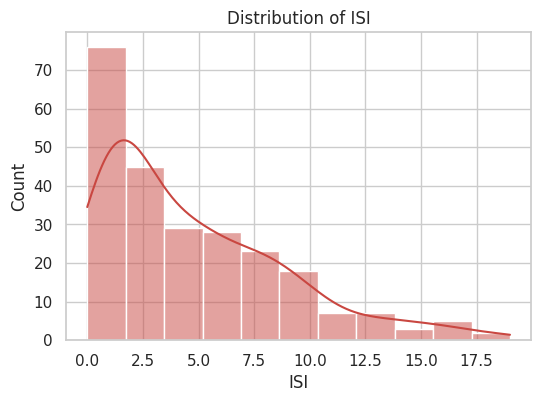

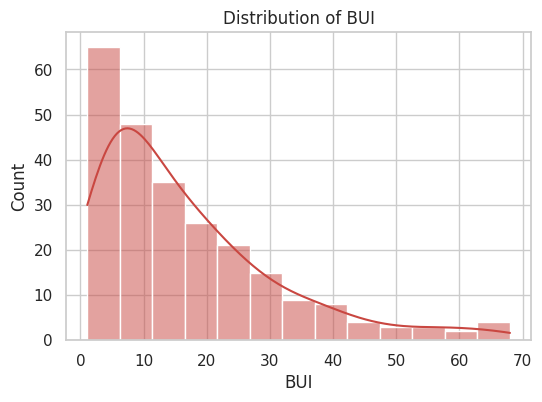

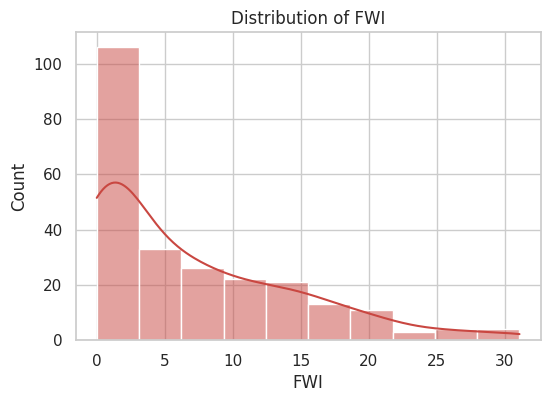

In [599]:
numerical_features = ['Temperature', 'RH', 'Ws', 'Rain', 'FFMC', 'DMC', 'DC', 'ISI', 'BUI', 'FWI']
for feature in numerical_features:
    plt.figure(figsize=(6, 4))
    sns.histplot(x=feature, data=df, kde=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.show()

In [ ]:
# Null Hypothesis:  There is no difference in average temperature between fire and non-fire days.
# Alternative Hypothesis:  There is a difference in average temperature between fire and non-fire days.
temp_fire = df[df['Classes'] == 1]['Temperature']
temp_no_fire = df[df['Classes'] == 0]['Temperature']
t_statistic, p_value = stats.ttest_ind(temp_fire, temp_no_fire)
print(f"Temperature vs. Fire Occurrence: t-statistic = {t_statistic:.3f}, p-value = {p_value:.4f}")


In [ ]:
# Null Hypothesis:  There is no difference in average wind speed between fire and non-fire days.
# Alternative Hypothesis:  There is a difference in average wind speed between fire and non-fire days.
ws_fire = df[df['Classes'] == 1]['Ws']
ws_no_fire = df[df['Classes'] == 0]['Ws']
t_statistic, p_value = stats.ttest_ind(ws_fire, ws_no_fire)
print(f"Wind Speed vs. Fire Occurrence: t-statistic = {t_statistic:.3f}, p-value = {p_value:.4f}")


In [ ]:
# Feature Generation
# Create new features based on existing ones
df['Temp_RH'] = df['Temperature'] * df['RH']
df['Wind_Rain'] = df['Ws'] * df['Rain']

In [ ]:
# Exploratory Data Analysis (EDA)
# Visualize relationships between variables
sns.heatmap(df.corr(), annot=True)
plt.title('Correlation Heatmap')
plt.show()

In [ ]:

# 5.  Fuel Characteristics (FFMC, DMC, DC) and Fire Occurrence
#  - Multiple Regression Analysis to see how these variables combinedly impact fire occurrence.
model = sm.ols('Classes ~ FFMC + DMC + DC', data=df)
results = model.fit()
print(results.summary())

In [ ]:
# Separate features (X) and target (y)
X = df.drop('Classes', axis=1)
y = df['Classes']


In [ ]:

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:

# Feature Selection
# Select K best features using chi-squared test
selector = SelectKBest(chi2, k=10)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)


In [ ]:

# Model Selection

# Define models to evaluate
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier()
}


In [ ]:

# Evaluate models using cross-validation
results = []
for name, model in models.items():
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_results = cross_val_score(model, X_train_selected, y_train, cv=kfold, scoring='accuracy')
    results.append((name, cv_results.mean()))


In [ ]:

# Display model performance
print('Model Accuracy:')
for name, accuracy in results:
    print(f'{name}: {accuracy:.4f}')


In [ ]:

# Hyperparameter Tuning
# Select the best-performing model and tune hyperparameters using grid search
best_model_name, _ = max(results, key=lambda item: item[1])
best_model = models[best_model_name]


In [ ]:

# Define hyperparameter grid for tuning
param_grid = {
    'Logistic Regression': {'C': [0.01, 0.1, 1, 10], 'penalty': ['l1', 'l2']},
    'Decision Tree': {'max_depth': [3, 5, 7, 9, None], 'criterion': ['gini', 'entropy']},
    'Random Forest': {'n_estimators': [50, 100, 200], 'max_depth': [3, 5, 7, 9, None]},
    'K-Nearest Neighbors': {'n_neighbors': [3, 5, 7, 9], 'weights': ['uniform', 'distance']}
}


In [ ]:
grid = GridSearchCV(best_model, param_grid[best_model_name], cv=5, scoring='accuracy')
grid.fit(X_train_selected, y_train)


In [ ]:
# Print best parameters and accuracy
print(f'Best parameters for {best_model_name}: {grid.best_params_}')
print(f'Best accuracy for {best_model_name}: {grid.best_score_:.4f}')

# Model Training and Evaluation
# Train the best model with tuned hyperparameters
best_model = grid.best_estimator_
best_model.fit(X_train_selected, y_train)


In [ ]:
# Predict on the test set
y_pred = best_model.predict(X_test_selected)


In [ ]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {accuracy:.4f}')
print(classification_report(y_test, y_pred))


In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Check Model Assumptions

# Check for multicollinearity
vif = [variance_inflation_factor(X_train_selected, i) for i in range(X_train_selected.shape[1])]
print('Variance Inflation Factors:')
print(vif)


In [ ]:
# Check for linearity
# Use scatter plots or residual plots to visualize linearity between features and target
for col in X_train_selected:
    plt.scatter(X_train_selected[col], y_train)
    plt.xlabel(col)
    plt.ylabel('Classes')
    plt.title(f'Scatter Plot of {col} vs. Classes')
    plt.show()

### 4. Conclusion

EDA Insights: Summarize your observations from the EDA plots.

Hypothesis Testing Results: Discuss the results of your hypothesis tests and their implications.

Model Performance: Report the accuracy of your chosen model and its performance on the test set.

Model Assumptions: Discuss any model assumptions and how you checked for them.

Future Work: Suggest potential areas for further exploration or improvement.

This analysis provides a starting point for understanding forest fire occurrences and developing prediction models. You can further enhance this analysis by incorporating more advanced techniques and features as needed.

Remember to adapt this code and analysis according to your specific data and research question.